In [54]:
import os
import pandas as pd
import tensorflow as tf
import cv2 ###open cv
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall

In [56]:
import numpy as np
import matplotlib.pyplot as plt

In [68]:
BASE_DIR = os.path.dirname(os.getcwd())
BASE_DIR

'/Users/kitty.mad/code/Kriskitt/melanoma_detector'

In [69]:
METADATA_PATH = os.path.join(BASE_DIR, 'data', 'metadata', 'metadata.csv')
IMG_FOLDER_PATH = os.path.join(BASE_DIR, 'data', 'images')

In [70]:
metadata = pd.read_csv(METADATA_PATH)

In [71]:
### 1 alto / 0 bajo
def label_risk(row):
    if row['diagnostic'] in ['SCC', 'BCC', 'MEL']:
        return 1
    else:
        return 0

metadata['risk_label'] = metadata.apply(label_risk, axis=1)
pd.DataFrame(metadata['risk_label'])

,risk_label
0,0
1,1
2,0
3,0
4,1
...,...
2293,0
2294,1
2295,0
2296,1


In [72]:
##trains, test, vals
train_df, temp_df = train_test_split(metadata, test_size=0.3, stratify=metadata['risk_label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['risk_label'])

In [73]:
def preprocess_image(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0  # Normalizar
    return image


In [74]:
def create_dataset(metadata, img_folder):
    img_paths = metadata['img_id'].apply(lambda x: f"{img_folder}/{x}").values
    labels = metadata['risk_label'].values
    images = []
    processed_labels = []
    for img_path, label in zip(img_paths, labels):
        image = preprocess_image(img_path)
        images.append(image)
        processed_labels.append(label)
    return tf.data.Dataset.from_tensor_slices((images, processed_labels))

In [75]:
img_folder = IMG_FOLDER_PATH

In [76]:
train_ds = create_dataset(train_df, img_folder).batch(32).shuffle(100)
val_ds = create_dataset(val_df, img_folder).batch(32)
test_ds = create_dataset(test_df, img_folder).batch(32)

In [77]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet') ##investigar pretrained
base_model.trainable = False

In [92]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [94]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])

In [95]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [96]:
es_callback = EarlyStopping(monitor='val_recall', patience=5, mode='max')

In [97]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[es_callback]
)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 341ms/step - loss: 0.6596 - recall_3: 0.6092 - val_loss: 0.5190 - val_recall_3: 0.6159
Epoch 2/100


/Users/kitty.mad/.pyenv/versions/3.10.6/envs/melanoma/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: loss,recall_3,val_loss,val_recall_3
  current = self.get_monitor_value(logs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 335ms/step - loss: 0.5026 - recall_3: 0.6972 - val_loss: 0.5130 - val_recall_3: 0.7988
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 327ms/step - loss: 0.4645 - recall_3: 0.7600 - val_loss: 0.4959 - val_recall_3: 0.6646
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - loss: 0.4220 - recall_3: 0.7517 - val_loss: 0.4914 - val_recall_3: 0.7927
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.3769 - recall_3: 0.8134 

KeyboardInterrupt: 

In [101]:
evaluation = model.evaluate(test_ds)
print("Evaluación en conjunto de prueba:", evaluation)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - loss: 0.5779 - recall_3: 0.5139
Evaluación en conjunto de prueba: [0.5759482383728027, 0.5337423086166382]


In [110]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- RECALL

    ax[1].plot(history.history['recall_3'])
    ax[1].plot(history.history['val_recall_3'])
    ax[1].set_title('Model Recall')
    ax[1].set_ylabel('Recall')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

KeyError: 'recall_3'

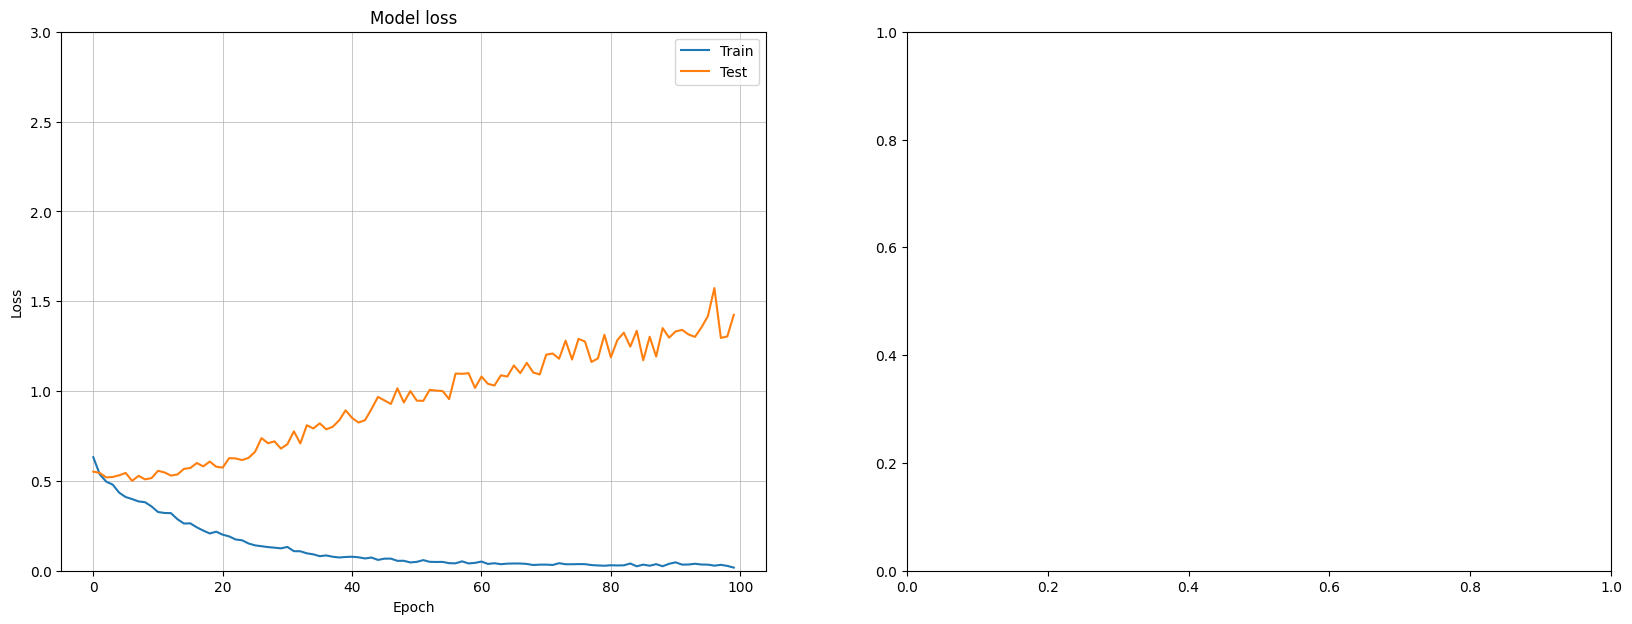

In [111]:
plot_loss_accuracy(history)

In [88]:
def predict_image(img_path):
    image = preprocess_image(img_path)
    image = tf.expand_dims(image, axis=0)  # Agregar dimensión batch
    prediction = model.predict(image)
    risk = "Alto riesgo" if prediction[0][0] > 0.5 else "Bajo riesgo"
    return risk

In [89]:
new_input = '/Users/kitty.mad/code/Kriskitt/melanoma_detector/data/upload/testtest_2.jpg'
resultado = predict_image(new_input)
print(f"La predicción para la imagen es: {resultado}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
La predicción para la imagen es: Alto riesgo
